In [1]:
# ✅ Import Required Libraries
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import shutil
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# ✅ Set a fixed random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✅ Random Seed Set!")

✅ Random Seed Set!


In [2]:
# ✅ Define Dataset Paths
data_dir = "/Users/dixitrikhari/Downloads/brain-tumour-org/Brain_Tumour_Dataset"
split_data_dir = "/Users/dixitrikhari/Downloads/brain-tumour-org/Split_Brain_Tumour_Dataset"

# ✅ Create Split Directories
train_dir = os.path.join(split_data_dir, "train")
val_dir = os.path.join(split_data_dir, "val")

for split in [train_dir, val_dir]:
    os.makedirs(split, exist_ok=True)

print("✅ Train & Validation directories created successfully!")

✅ Train & Validation directories created successfully!


In [3]:
# ✅ Function to Split Dataset
def split_dataset(source_dir, train_dest, val_dest, split_ratio=0.8):
    categories = ["Brain_Tumour", "Healthy"]
    for category in categories:
        os.makedirs(os.path.join(train_dest, category), exist_ok=True)
        os.makedirs(os.path.join(val_dest, category), exist_ok=True)

        source_path = os.path.join(source_dir, category)
        images = [img for img in os.listdir(source_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        
        random.shuffle(images)  # Shuffle images
        train_size = int(len(images) * split_ratio)
        train_images = images[:train_size]
        val_images = images[train_size:]

        for img in train_images:
            shutil.copy(os.path.join(source_path, img), os.path.join(train_dest, category, img))

        for img in val_images:
            shutil.copy(os.path.join(source_path, img), os.path.join(val_dest, category, img))

# ✅ Perform Dataset Split
split_dataset(data_dir, train_dir, val_dir)

print("✅ Dataset successfully split into Training (80%) & Validation (20%)!")

✅ Dataset successfully split into Training (80%) & Validation (20%)!


In [4]:
# ✅ Define Transformations (Resizing, Flipping, Rotation, Normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Train & Validation Datasets
train_set = ImageFolder(train_dir, transform=transform)
val_set = ImageFolder(val_dir, transform=transform)

# ✅ Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

# ✅ Print Dataset Size
print(f"🔹 Training Set: {len(train_set)} images")
print(f"🔹 Validation Set: {len(val_set)} images")

🔹 Training Set: 3551 images
🔹 Validation Set: 889 images


In [5]:
# ✅ Define CNN Architecture
class CNN_TUMOR(nn.Module):
    def __init__(self, params):
        super(CNN_TUMOR, self).__init__()
        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # CNN Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(Cin, init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(init_f, 2 * init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(2 * init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(4 * init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(8 * init_f),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(8 * init_f * 16 * 16, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        X = X.view(X.shape[0], -1)  # Flatten
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

# ✅ Define Model Parameters
params_model = {
    "shape_in": (3, 256, 256),
    "initial_filters": 16,
    "num_fc1": 256,
    "dropout_rate": 0.2,  # Optimized Dropout
    "num_classes": 2
}

# ✅ Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN_TUMOR(params_model).to(device)

In [6]:
# ✅ Compute Class Weights for Balanced Training
class_counts = [len(os.listdir(os.path.join(train_dir, c))) for c in ["Brain_Tumour", "Healthy"]]
class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=[0] * class_counts[0] + [1] * class_counts[1])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# ✅ Define Loss Function, Optimizer, & Learning Rate Scheduler
loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=10, verbose=1)

# ✅ Train model (Fixed Version)
epochs = 30
loss_history = {"train": [], "val": []}
metric_history = {"train": [], "val": []}

for epoch in range(epochs):
    cnn_model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # ✅ Compute Train Accuracy
    train_acc = 100.0 * correct / total
    loss_history["train"].append(train_loss / len(train_loader))  # ✅ Fix: Append average loss
    metric_history["train"].append(train_acc)  # ✅ Fix: Append train accuracy

    # ✅ Validation Step
    cnn_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # ✅ Compute Validation Accuracy
    val_acc = 100.0 * correct / total
    loss_history["val"].append(val_loss / len(val_loader))  # ✅ Fix: Append average validation loss
    metric_history["val"].append(val_acc)  # ✅ Fix: Append validation accuracy

    # ✅ Learning Rate Scheduler Step
    lr_scheduler.step(val_loss)

    print(f"🔹 Epoch {epoch+1}/{epochs} - Train Loss: {loss_history['train'][-1]:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {loss_history['val'][-1]:.4f}, Val Acc: {val_acc:.2f}%")

print("✅ Training Completed!")
    
# ✅ Save Model
torch.save(cnn_model.state_dict(), "trained_cnn_model.pth")
print("✅ Model Saved Successfully!")

🔹 Epoch 1/30 - Train Loss: 0.8387, Train Acc: 66.46%, Val Loss: 0.4671, Val Acc: 77.39%
🔹 Epoch 2/30 - Train Loss: 0.3985, Train Acc: 81.89%, Val Loss: 0.3647, Val Acc: 85.38%
🔹 Epoch 3/30 - Train Loss: 0.3368, Train Acc: 85.36%, Val Loss: 0.2856, Val Acc: 88.75%
🔹 Epoch 4/30 - Train Loss: 0.3115, Train Acc: 86.31%, Val Loss: 0.3250, Val Acc: 86.84%
🔹 Epoch 5/30 - Train Loss: 0.2652, Train Acc: 88.54%, Val Loss: 0.2718, Val Acc: 87.85%
🔹 Epoch 6/30 - Train Loss: 0.2358, Train Acc: 90.12%, Val Loss: 0.2437, Val Acc: 90.66%
🔹 Epoch 7/30 - Train Loss: 0.2300, Train Acc: 90.48%, Val Loss: 0.2817, Val Acc: 86.95%
🔹 Epoch 8/30 - Train Loss: 0.2176, Train Acc: 90.59%, Val Loss: 0.2066, Val Acc: 90.55%
🔹 Epoch 9/30 - Train Loss: 0.2019, Train Acc: 91.55%, Val Loss: 0.2505, Val Acc: 89.99%
🔹 Epoch 10/30 - Train Loss: 0.1825, Train Acc: 92.59%, Val Loss: 0.1815, Val Acc: 92.80%
🔹 Epoch 11/30 - Train Loss: 0.1744, Train Acc: 93.41%, Val Loss: 0.1740, Val Acc: 93.81%
🔹 Epoch 12/30 - Train Loss: 0.

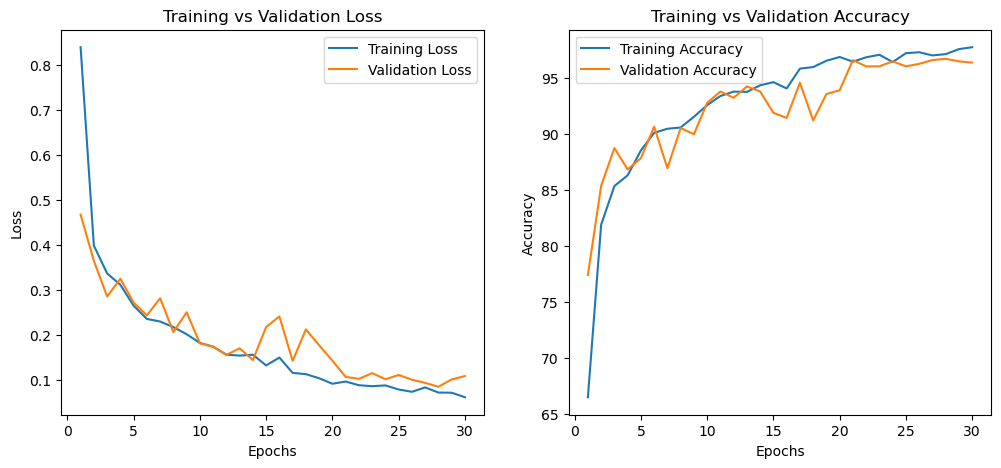

In [9]:
import matplotlib.pyplot as plt

# ✅ Function to Plot Training & Validation Loss & Accuracy
def plot_training_history(loss_history, metric_history):
    epochs = range(1, len(loss_history["train"]) + 1)

    # ✅ Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history["train"], label="Training Loss")
    plt.plot(epochs, loss_history["val"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # ✅ Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metric_history["train"], label="Training Accuracy")
    plt.plot(epochs, metric_history["val"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.show()

# ✅ Call the function to plot graphs
plot_training_history(loss_history, metric_history)

📊 Classification Report:

              precision    recall  f1-score   support

 Brain Tumor       0.95      0.99      0.97       472
     Healthy       0.99      0.94      0.97       417

    accuracy                           0.97       889
   macro avg       0.97      0.97      0.97       889
weighted avg       0.97      0.97      0.97       889



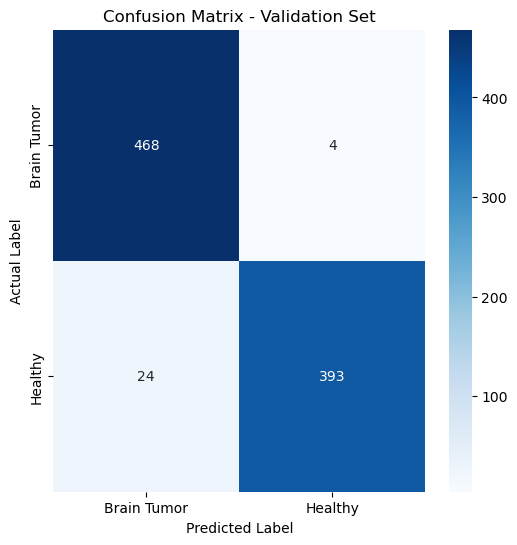

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

# ✅ Disable gradient calculation (for inference)
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass (prediction)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability

        # Store labels
        y_true.extend(labels.cpu().numpy())  # Move to CPU and convert to NumPy
        y_pred.extend(predicted.cpu().numpy())  # Move to CPU and convert to NumPy

# ✅ Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Define Class Names
class_names = ["Brain Tumor", "Healthy"]

# ✅ Generate Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("📊 Classification Report:\n")
print(report)

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [22]:
import pickle

# ✅ Define Save Path
model_save_path = "/Users/dixitrikhari/Downloads/brain-tumour-org/trained_cnn_model.pkl"

# ✅ Save Model as Pickle File
with open(model_save_path, "wb") as f:
    pickle.dump(cnn_model.state_dict(), f)

print(f"✅ Model Saved Successfully at {model_save_path}!")

✅ Model Saved Successfully at /Users/dixitrikhari/Downloads/brain-tumour-org/trained_cnn_model.pkl!


✅ Model Loaded Successfully!

🔹 Classification Report:

              precision    recall  f1-score   support

Brain_Tumour       0.96      0.99      0.97       472
     Healthy       0.99      0.95      0.97       417

    accuracy                           0.97       889
   macro avg       0.97      0.97      0.97       889
weighted avg       0.97      0.97      0.97       889



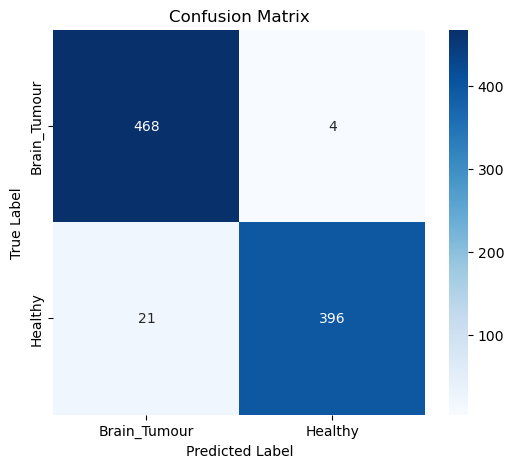

In [23]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Load Model
model_save_path = "/Users/dixitrikhari/Downloads/brain-tumour-org/trained_cnn_model.pkl"

with open(model_save_path, "rb") as f:
    state_dict = pickle.load(f)

cnn_model.load_state_dict(state_dict)
cnn_model.to(device)
cnn_model.eval()

print("✅ Model Loaded Successfully!")

# ✅ Evaluate Model on Validation Set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Print Classification Report
print("\n🔹 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Brain_Tumour", "Healthy"]))

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Brain_Tumour", "Healthy"], yticklabels=["Brain_Tumour", "Healthy"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()